## Import Libraries

In [16]:
import importlib
import os

try:
    importlib.reload(dataloaders)
    importlib.reload(models)
except:
    import dataloaders
    import models

## Load Data

In [17]:
file = os.path.abspath("all_molecules.csv")
dataloader = dataloaders.DataLoader(file)

In [18]:
descriptors = dataloader.get_molecular_descriptors()
descriptors.shape

(2000, 209)

In [19]:
labels = dataloader.get_labels()
labels.shape

(2000, 1)

## PCA Analysis

In [11]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [50]:
df_descriptors = dataloader.get_molecular_descriptors_dataframe()

In [51]:
# df_descriptors.head()
corr_matrix = df_descriptors.corr()

# Create an empty list to store the highly correlated pairs
highly_correlated_pairs = []

# Loop through the correlation matrix and find pairs with correlations higher than 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            # Add the pair of column names to the list
            pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            highly_correlated_pairs.append(pair)

# Print the list of highly correlated pairs
len(highly_correlated_pairs)


126

In [53]:
# Create a set to keep track of columns to delete
columns_to_delete = set()

# Delete one column from each correlated pair
for pair in highly_correlated_pairs:
    column1, column2 = pair
    if column1 not in columns_to_delete:
        columns_to_delete.add(column2)
    elif column2 not in columns_to_delete:
        columns_to_delete.add(column1)

len(list(columns_to_delete))

# Delete the columns from the original DataFrame
df_descriptors = df_descriptors.drop(columns=list(columns_to_delete))


# Print the modified DataFrame
df_descriptors.shape

(2000, 179)

In [54]:
PCA_data = df_descriptors.copy()
scaler = MinMaxScaler()
PCA_data_scaled = scaler.fit_transform(PCA_data)

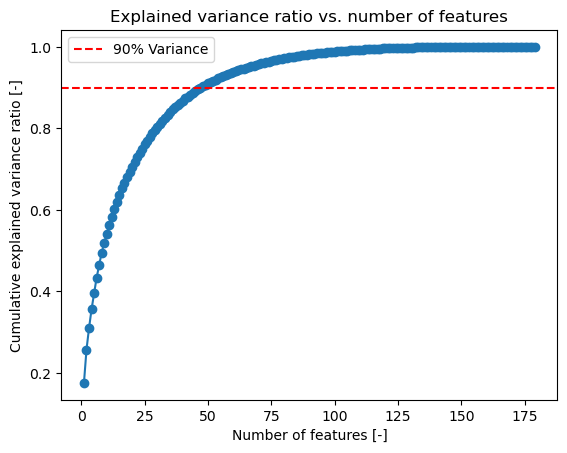

48


In [55]:
pca = PCA()
pca.fit(PCA_data_scaled)

# Calculation of cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of features [-]')
plt.ylabel('Cumulative explained variance ratio [-]')
plt.title('Explained variance ratio vs. number of features')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.legend()
plt.savefig('Explained_variance.png', dpi=1000)
plt.show()

num_components = np.argmax(cumulative_var_ratio >= 0.9) + 1
print(num_components)

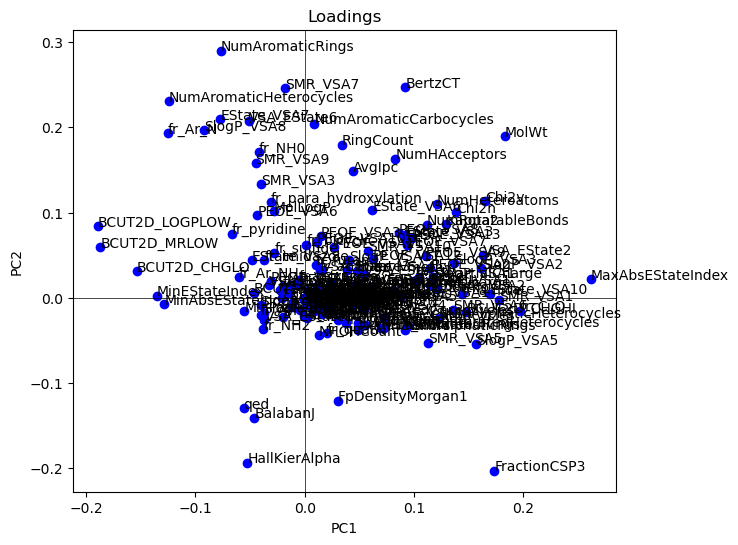

In [58]:
# Get the loadings
loadings = pca.components_

# Calculate the variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Create a variable names list
variable_names = PCA_data.columns

# Set the number of principal components to display on the loading plot
num_pc = len(loadings)

# Set the number of variables to display on the loading plot
num_vars = len(variable_names)

# Plot the loading plot using a scatter plot
plt.figure(figsize=(7, 6))
for i in range(num_vars):
    plt.scatter(loadings[0, i], loadings[1, i], color='b')
    plt.text(loadings[0, i], loadings[1, i], variable_names[i])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loadings')
plt.show()

In [57]:
# Assuming you have the original DataFrame called 'df' with 179 features
# Here's an example DataFrame  # Your data here

# Perform PCA
pca = PCA(n_components=48)  # Choose the number of components that explain 90% of the variance
principal_components = pca.fit_transform(PCA_data_scaled)

# Get the loadings for each feature in the principal components
loadings = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(48)], index=PCA_data.columns)

# Calculate the average absolute loading for each feature
average_loadings = loadings.abs().mean(axis=1)

# Rank the features based on average loadings in descending order
feature_ranking = average_loadings.sort_values(ascending=False)

print(feature_ranking)

fr_para_hydroxylation    0.111254
EState_VSA6              0.110125
PEOE_VSA8                0.104426
fr_hdrzine               0.102450
fr_pyridine              0.101572
                           ...   
fr_prisulfonamd          0.000000
fr_HOCCN                 0.000000
fr_isocyan               0.000000
fr_phos_ester            0.000000
SlogP_VSA9               0.000000
Length: 179, dtype: float64


## Model training

In [5]:
model = models.Model(descriptors, labels)

descriptors = model.preprocessing()

c:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q4\Advanced Programming\8CC00Code\GroupAssignment\models.py:17: RuntimeWarning: invalid value encountered in divide
  self.x = (self.x - min_val) / (max_val - min_val)


In [6]:
model.train()

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('pca', PCA(n_components=20)),
                ('classifier', RandomForestClassifier())])

In [7]:
accuracy = model.test()
print(accuracy)

0.7775
